In [1]:
import pandas as pd

df = pd.read_csv("Merged_Microplastic_Data.csv")

null_counts = df.isnull().sum()
print(null_counts)

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64


In [2]:
df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
4,4,10.1039/c6ay01184e,1|10.1039/c6ay01184e,Germany,Germany,bottled water,19-Oct,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
604,604,10.1016/j.scitotenv.2021.148001,Aut|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,750,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
605,605,10.1016/j.scitotenv.2021.148001,Win|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,540,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


In [3]:
print(df.info())

# Show the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Get summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            607 non-null    int64  
 1   DOI                                   607 non-null    object 
 2   Sample_ID                             607 non-null    object 
 3   Location                              458 non-null    object 
 4   Countries                             458 non-null    object 
 5   Source                                607 non-null    object 
 6   Concentration                         601 non-null    object 
 7   Concentration_Units                   601 non-null    object 
 8   Approximate_Latitude                  452 non-null    float64
 9   Approximate_Longitude                 452 non-null    float64
 10  Sample_device_and_deployment_methods  586 non-null    object 
 11  Digestion          

In [4]:
# Drop the 'Unnamed: 0' column as it's just an index
df = df.drop(columns=["Unnamed: 0"])

# Handle missing values (drop rows or fill them based on the analysis)
df = df.dropna(subset=["Location", "Countries", "Concentration"])

# Convert 'Concentration' to numeric values, removing non-numeric characters
df['Concentration'] = pd.to_numeric(df['Concentration'].str.extract('(\d+.\d+)')[0], errors='coerce')

# Convert 'Approximate_Latitude' and 'Approximate_Longitude' to float (if not already)
df['Approximate_Latitude'] = pd.to_numeric(df['Approximate_Latitude'], errors='coerce')
df['Approximate_Longitude'] = pd.to_numeric(df['Approximate_Longitude'], errors='coerce')

# Verify the changes
print(df.info())
print(df.head())

# Check if any rows still have missing concentration or coordinates
print(df[['Concentration', 'Approximate_Latitude', 'Approximate_Longitude']].isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 453 entries, 0 to 606
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DOI                                   453 non-null    object 
 1   Sample_ID                             453 non-null    object 
 2   Location                              453 non-null    object 
 3   Countries                             453 non-null    object 
 4   Source                                453 non-null    object 
 5   Concentration                         258 non-null    float64
 6   Concentration_Units                   453 non-null    object 
 7   Approximate_Latitude                  447 non-null    float64
 8   Approximate_Longitude                 447 non-null    float64
 9   Sample_device_and_deployment_methods  432 non-null    object 
 10  Digestion                             432 non-null    object 
 11  Filtration              

DOI                                     0
Sample_ID                               0
Location                                0
Countries                               0
Source                                  0
Concentration                           0
Concentration_Units                     0
Approximate_Latitude                    0
Approximate_Longitude                   0
Sample_device_and_deployment_methods    0
Digestion                               0
Filtration                              0
Filter_Size                             0
Microplastic_Identification_Method      0
Spectral_Analysis                       0
Controls                                0
dtype: int64


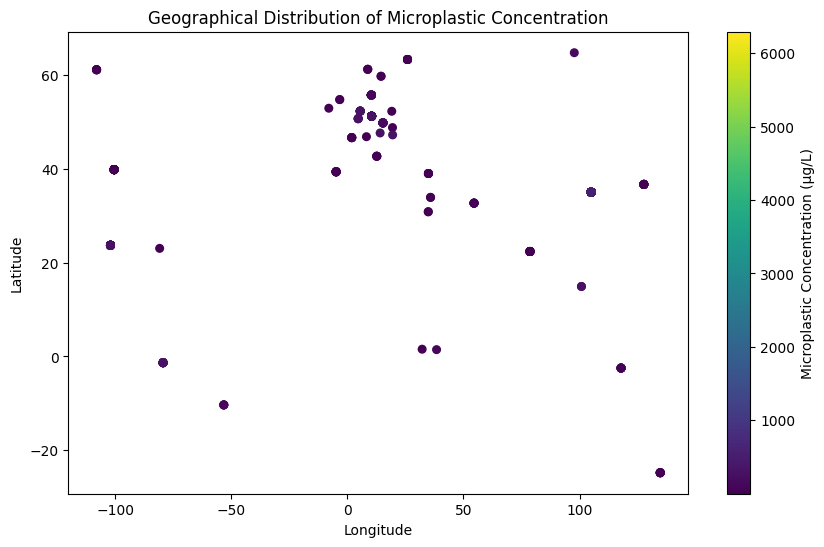

In [5]:
import matplotlib.pyplot as plt

# Handle missing values in 'Concentration' by filling with the mean (or drop rows if preferred)
df['Concentration'] = df['Concentration'].fillna(df['Concentration'].mean())  # Or df.dropna(subset=['Concentration'])

# Handle missing latitude and longitude by dropping rows with missing values
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])

# Fill missing values in other columns with 'Unknown' (if needed)
df = df.fillna('Unknown')

# Verify the changes
print(df.isnull().sum())

# Plotting the locations on a scatter plot (Latitude vs. Longitude)
plt.figure(figsize=(10, 6))
plt.scatter(df['Approximate_Longitude'], df['Approximate_Latitude'], c=df['Concentration'], cmap='viridis', s=30)
plt.title("Geographical Distribution of Microplastic Concentration")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Microplastic Concentration (µg/L)')
plt.show()


In [7]:
# Get summary statistics for the concentration values
print(df['Concentration'].describe())

count     447.000000
mean      278.999091
std       539.238097
min         0.000002
25%         3.875000
50%       276.543778
75%       276.543778
max      6292.000000
Name: Concentration, dtype: float64


In [8]:
# Checking correlation between concentration and geolocation
correlation = df[['Concentration', 'Approximate_Latitude', 'Approximate_Longitude']].corr()
print(correlation)


                       Concentration  Approximate_Latitude  \
Concentration               1.000000              0.040004   
Approximate_Latitude        0.040004              1.000000   
Approximate_Longitude       0.086948             -0.054085   

                       Approximate_Longitude  
Concentration                       0.086948  
Approximate_Latitude               -0.054085  
Approximate_Longitude               1.000000  


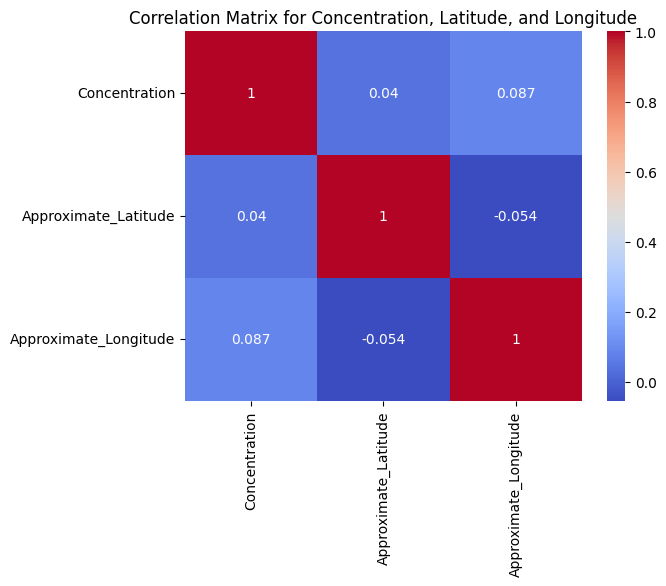

In [9]:
import seaborn as sns

# Plotting a heatmap of the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Concentration, Latitude, and Longitude')
plt.show()


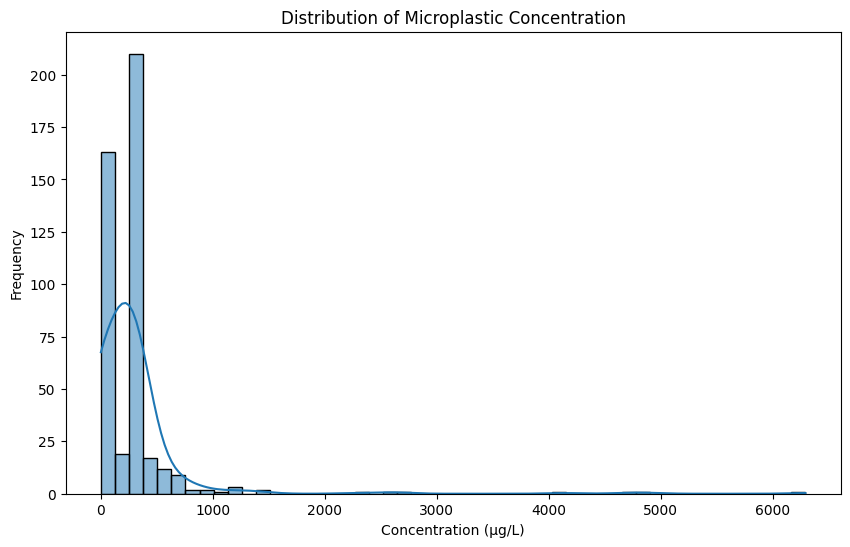

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Concentration'], kde=True, bins=50)
plt.title("Distribution of Microplastic Concentration")
plt.xlabel("Concentration (µg/L)")
plt.ylabel("Frequency")
plt.show()


### Microplastic Concentration by Filtration Method

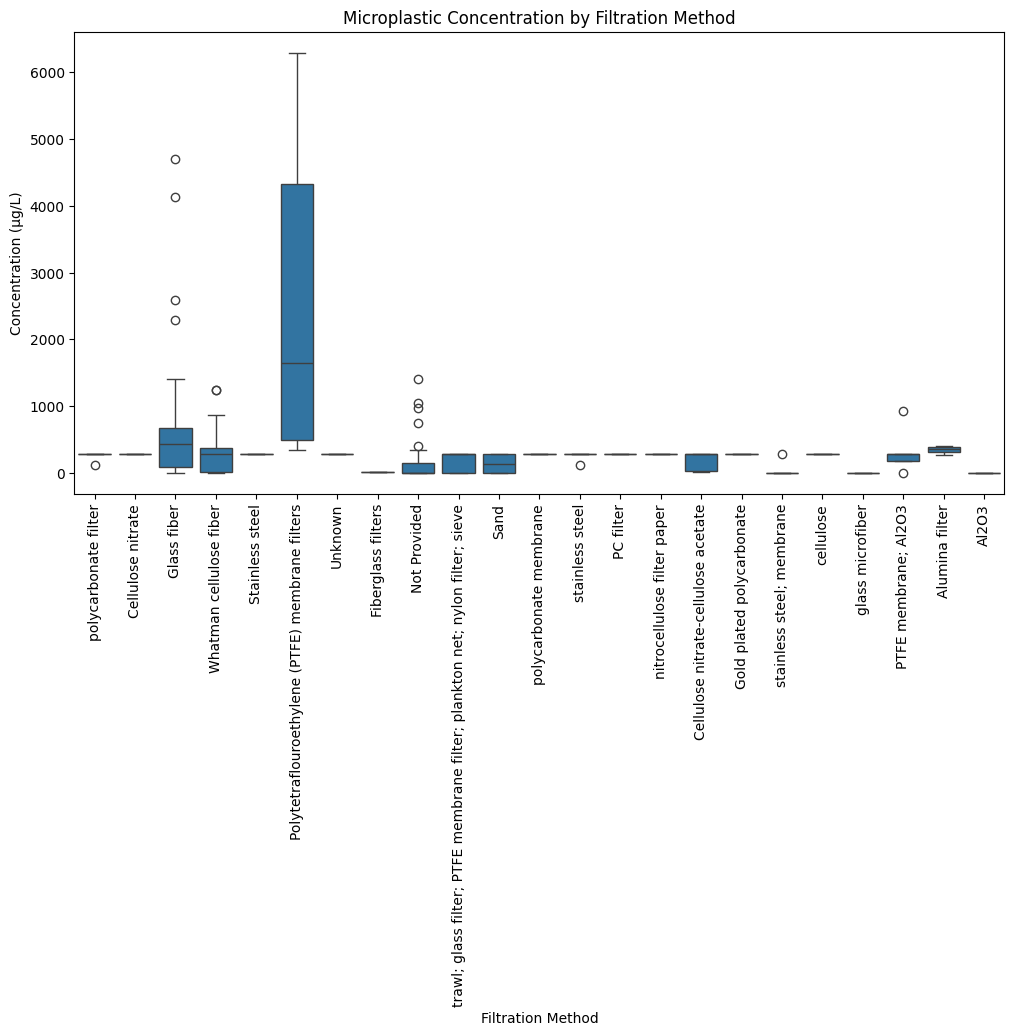

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Filtration', y='Concentration')
plt.title("Microplastic Concentration by Filtration Method")
plt.xlabel("Filtration Method")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=90)
plt.show()


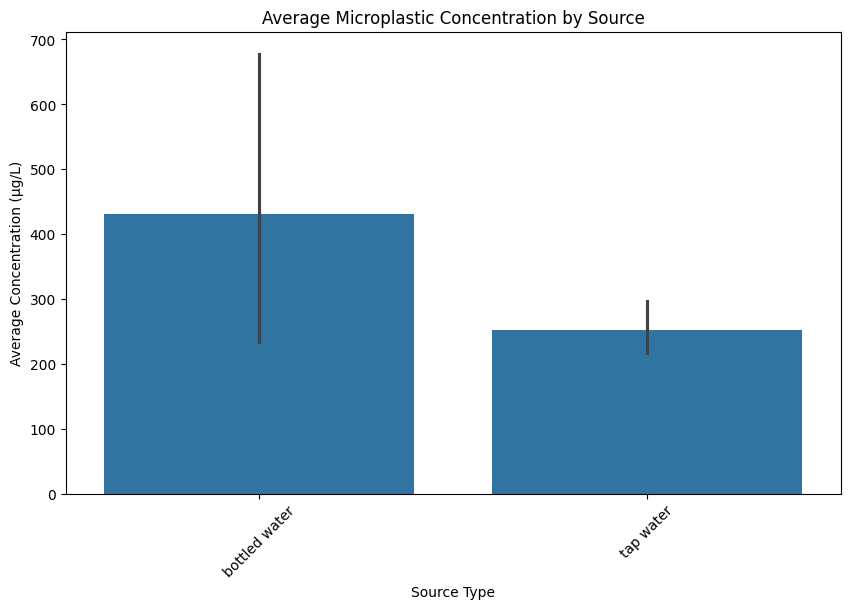

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Source', y='Concentration', estimator='mean')
plt.title("Average Microplastic Concentration by Source")
plt.xlabel("Source Type")
plt.ylabel("Average Concentration (µg/L)")
plt.xticks(rotation=45)
plt.show()


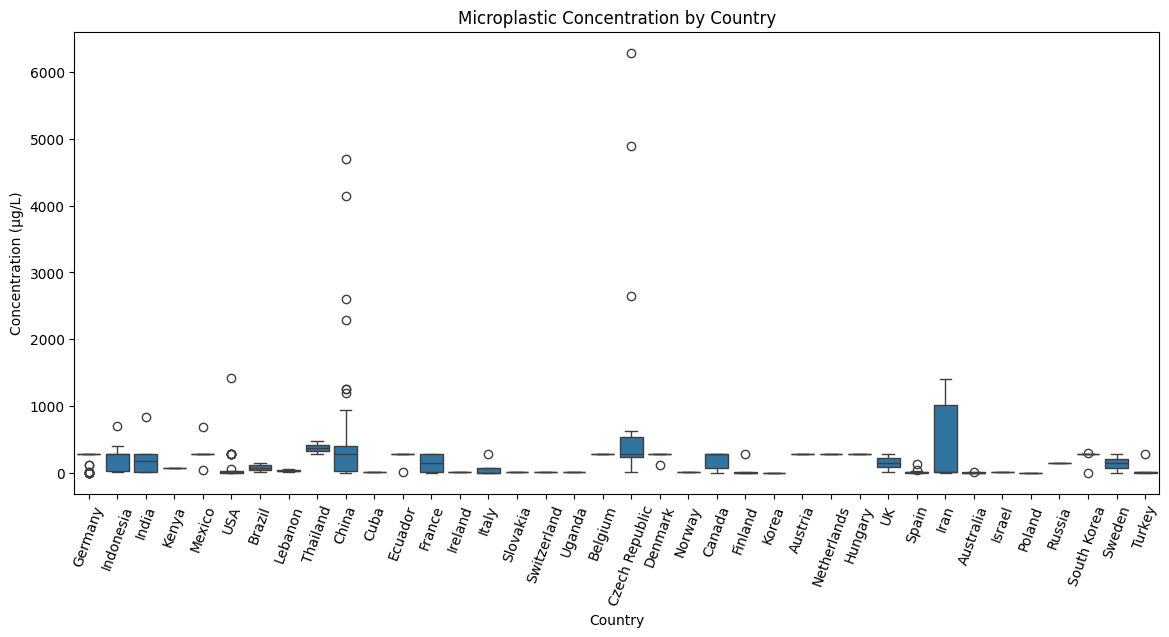

In [34]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='Countries', y='Concentration')
plt.title("Microplastic Concentration by Country")
plt.xlabel("Country")
plt.ylabel("Concentration (µg/L)")
plt.xticks(rotation=70)
plt.show()


<Figure size 1200x600 with 0 Axes>

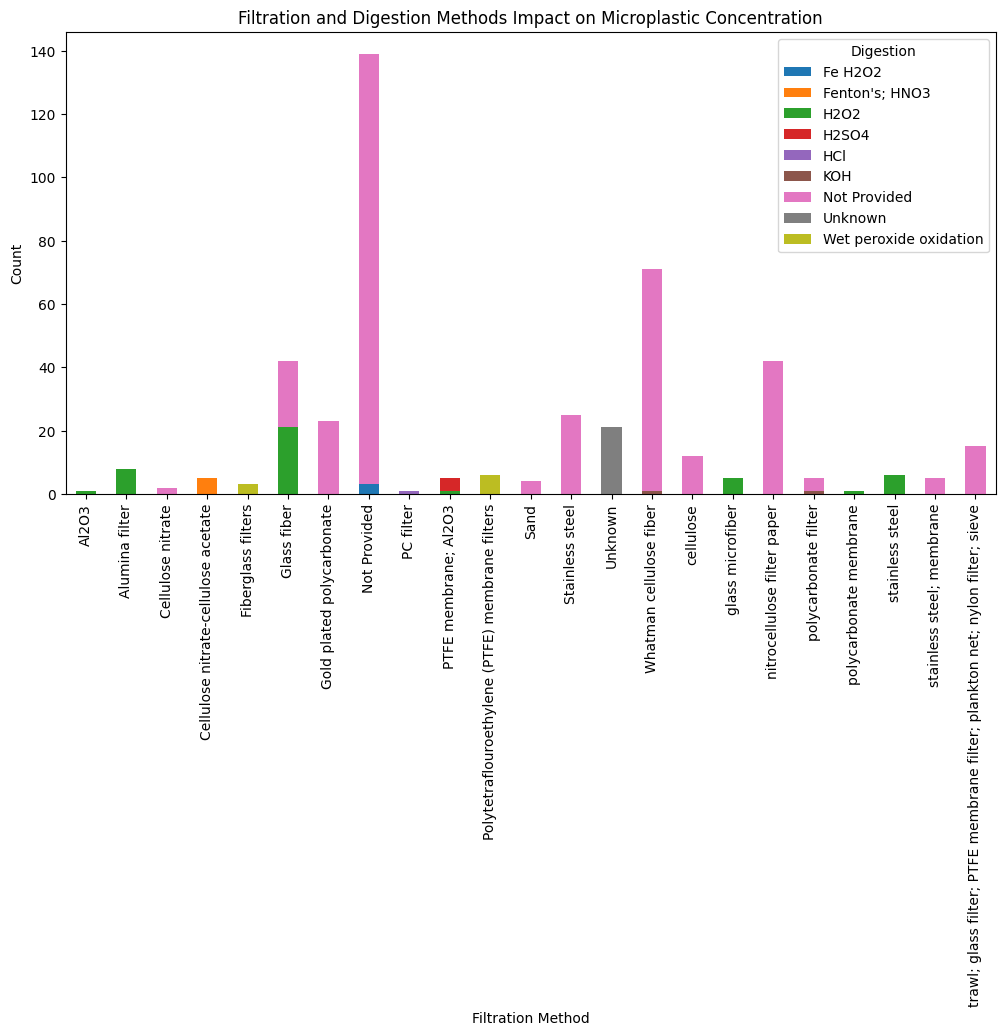

In [35]:
plt.figure(figsize=(12, 6))
filtration_digestion_group = df.groupby(['Filtration', 'Digestion']).size().unstack()
filtration_digestion_group.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Filtration and Digestion Methods Impact on Microplastic Concentration")
plt.xlabel("Filtration Method")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()


In [36]:
from scipy import stats
filtration_groups = df.groupby('Filtration')['Concentration'].apply(list)
digestion_groups = df.groupby('Digestion')['Concentration'].apply(list)

# Perform ANOVA for Filtration Methods
f_stat, p_val = stats.f_oneway(*filtration_groups)
print(f"ANOVA result for Filtration methods: F-statistic = {f_stat}, p-value = {p_val}")

# Perform ANOVA for Digestion Methods
f_stat, p_val = stats.f_oneway(*digestion_groups)
print(f"ANOVA result for Digestion methods: F-statistic = {f_stat}, p-value = {p_val}")


ANOVA result for Filtration methods: F-statistic = 9.768773508799617, p-value = 2.356820673683628e-26
ANOVA result for Digestion methods: F-statistic = 15.987085840947422, p-value = 9.358551230958465e-21


In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ANOVA model for Filtration methods
model = ols('Concentration ~ Filtration', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Tukey's HSD test
tukey = pairwise_tukeyhsd(df['Concentration'], df['Filtration'], alpha=0.05)
print(tukey)


                  sum_sq     df         F        PR(>F)
Filtration  4.362315e+07   22.0  9.768774  2.356821e-26
Residual    8.606372e+07  424.0       NaN           NaN
                                                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                            
                     group1                                                        group2                                     meandiff  p-adj    lower      upper    reject
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          Al2O3                                                               Alumina filter     347.55    1.0  -1391.718   2086.818  False
                                          Al2O3                                                            Cellulose nitrate   276.3438    1.0 -